In [2]:
import pandas as pd
import sys
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib as joblib
import tensorflow as tf
from tensorflow import keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import model_from_json,Model, load_model
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization,Add,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback, TensorBoard

import datetime
from sklearn.model_selection import train_test_split
import os

import copy

In [3]:
os.getcwd()

'd:\\orhan\\Belgeler\\GitHub\\Mantis-Shrimp-Eye-s-Collision-Avoidance\\dnn'

In [4]:
os.chdir("../")
os.getcwd()

'd:\\orhan\\Belgeler\\GitHub\\Mantis-Shrimp-Eye-s-Collision-Avoidance'

In [5]:
sys.path.append(os.getcwd()+"/tools")

In [6]:
from configmanager import ConfigurationManager
configurationManager = ConfigurationManager()

## Preprocess

In [8]:
dnn_dataset =  configurationManager.config_readable['dnn_dataset']
dnn_distance_model_folder = configurationManager.config_readable['dnn_distance_model_folder']


path_dnn_train = dnn_dataset+"fake_dnn_train.csv"
path_dnn_train = dnn_dataset+"dnn_train.csv"


df_train = pd.read_csv(path_dnn_train,usecols=["object_type","width","height", "range_distance"])


df_train

,object_type,width,height,range_distance
0,Helicopter,16.0,16.0,698.099154
1,Helicopter,16.0,16.0,692.553591
2,Helicopter,16.0,16.0,687.144329
3,Helicopter,16.0,16.0,681.758264
4,Helicopter,16.0,16.0,676.482461
...,...,...,...,...
18108,Helicopter,116.2,56.2,118.659839
18109,Helicopter,126.4,59.8,114.210813
18110,Helicopter,135.6,63.2,109.811127
18111,Helicopter,146.4,66.8,105.747778


In [9]:
df_train = df_train.sort_values('range_distance', ascending=True)
df_train

,object_type,width,height,range_distance
12737,Helicopter,143.200000,127.600000,26.440635
12736,Helicopter,354.200000,256.000000,29.932464
12735,Helicopter,282.000000,271.000000,33.585898
7495,Helicopter,26.153846,23.076923,36.513925
12734,Helicopter,233.102564,227.800000,37.497520
...,...,...,...,...
17900,Helicopter,16.000000,16.000000,699.615847
7626,Helicopter,16.000000,16.000000,699.642851
15450,Helicopter,16.000000,16.000000,699.719229
2161,Airplane,19.400000,6.400000,699.786453


In [ ]:
'''
@dataclass
class ObjectTypes(Enum):
    Airplane = 0
    Helicopter = 1
    Bird = 2
    Drone = 3
    Flock = 4
    Airborne = 5
'''

In [10]:
df_train['object_type'].replace('Airplane', 0, inplace=True)
df_train['object_type'].replace('Helicopter', 1, inplace=True)
df_train['object_type'].replace('Bird', 2, inplace=True)
df_train['object_type'].replace('Drone', 3, inplace=True)
df_train['object_type'].replace('Flock', 4, inplace=True)
df_train['object_type'].replace('Airborne', 5, inplace=True)


In [11]:
df_train.head(10)

,object_type,width,height,range_distance
12737,1,143.200000,127.600000,26.440635
12736,1,354.200000,256.000000,29.932464
12735,1,282.000000,271.000000,33.585898
7495,1,26.153846,23.076923,36.513925
12734,1,233.102564,227.800000,37.497520
11169,1,16.200000,25.600000,38.509356
7494,1,203.846154,147.692308,39.686723
12733,1,198.974359,195.384615,41.508921
11168,1,223.400000,147.400000,41.755642
7493,1,188.461538,230.000000,43.162551


In [12]:
df_train.tail(20)

,object_type,width,height,range_distance
12988,1,16.000000,16.00000,698.996028
2250,1,16.000000,16.00000,699.002229
254,1,6.000000,6.00000,699.026447
12738,1,16.000000,16.00000,699.038594
15190,0,30.600000,9.20000,699.069770
872,0,27.000000,7.20000,699.080159
1079,0,30.625708,13.57605,699.155745
9422,1,6.000000,6.00000,699.159678
4644,1,16.000000,16.00000,699.195704
2335,1,16.000000,16.00000,699.254026


In [8]:
'''df_train.width = df_train.width.astype(int)
df_train.height = df_train.height.astype(int)
df_train.range_distance = df_train.range_distance.astype(int)

df_train.head()'''

,object_type,width,height,range_distance
0,1,16,16,698
1,1,16,16,692
2,1,16,16,687
3,1,16,16,681
4,1,16,16,676


In [13]:
df_train.describe()

,object_type,width,height,range_distance
count,18113.000000,18113.000000,18113.000000,18113.000000
mean,0.830067,33.838660,23.826046,355.756348
std,0.375584,30.668841,17.217614,145.911359
min,0.000000,4.000000,6.000000,26.440635
25%,1.000000,16.000000,16.000000,251.951863
50%,1.000000,21.200000,17.800000,336.303429
75%,1.000000,41.935484,25.848560,441.788601
max,1.000000,361.204013,271.000000,699.794274


## Train

In [14]:
class DistanceTrain:

    def __init__(self,distance_folder_path,before_model=None,epoch=2000):

        self.path = distance_folder_path
        self.before_model = before_model
        self.epoch = epoch


    def distance_train(self, df_test):
        # ----------- import data and scaling ----------- #
        #df_train = pd.read_csv(path_dnn_train)
        #df_test = pd.read_csv(self.path + '/datasets/test.csv')

        #X_train = df_train[['xmin', 'ymin', 'xmax', 'ymax']].values
        X_train = df_test[['width', 'height', 'object_type']].values
        y_train = df_test[['range_distance']].values

        X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.1, random_state=123)

        #X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_train,y_train,train_size=.9, stratify=y_train)

        #X_test = df_test[['xmin', 'ymin', 'xmax', 'ymax']].values
        #y_test = df_test[['zloc']].values

        # standardized data
        x_scalar = StandardScaler()
        X_train = x_scalar.fit_transform(X_train)
        scaler_filename = self.path+"/xtrain_scaler.save"
        joblib.dump(x_scalar, scaler_filename)
        
        y_scalar = StandardScaler()
        y_train = y_scalar.fit_transform(y_train)
        scaler_filename = self.path+"/ytrain_scaler.save"
        scaler_filename = self.path+"/ytrain_scaler.save"
        joblib.dump(y_scalar, scaler_filename)
        
        # ----------- create model ----------- #
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(128, input_dim=3, kernel_initializer='normal', activation='relu'))
        model.add(tf.keras.layers.Dense(64, kernel_initializer='normal', activation='relu'))
        model.add(tf.keras.layers.Dense(32, kernel_initializer='normal', activation='relu'))
        model.add(tf.keras.layers.Dense(16, kernel_initializer='normal', activation='relu'))
        model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))

        #model = multi_gpu_model(model, gpus=2)

        initial_learning_rate = 0.1
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=100000,
            decay_rate=0.96,
            staircase=True)
        
        opt= tf.keras.optimizers.SGD(learning_rate=lr_schedule)
        
        
        opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        opt = 'adam' #ilk hali
        
        
        
        model.compile(loss='mean_squared_error', optimizer=opt)

        # ----------- define callbacks ----------- #
        earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
        #modelname = "model@{}".format(int(time.time()))
        #tensorboard = TensorBoard(log_dir=path+"logs/{}".format(modelname))
        
        modelname ="model_{}".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        log_dir = self.path+"/logs/fit/" + modelname
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        callbacks = [reduce_lr_loss,
                     earlyStopping,
                     tensorboard_callback]

        callbacks = [reduce_lr_loss,
                     earlyStopping]

        if self.before_model !=None:
            model.load_weights(self.path+"{}.h5".format(self.before_model))

        # ----------- start training ----------- #
        '''history = model.fit(X_train, y_train,
                                    validation_split=0.1, epochs=self.epoch, batch_size=4096,
                                    verbose=1, callbacks=callbacks,)'''
        
        history = model.fit(X_train, y_train,validation_split=0.15, epochs=self.epoch, batch_size=4096,verbose=1)

        # ----------- save model and weights ----------- #

        model.save(self.path+"{}.h5".format(modelname))
        print("model name:   "+ modelname)
        print("Saved model to disk")

In [15]:
before_model= None

epoch=1000

distance_train = DistanceTrain(distance_folder_path=dnn_distance_model_folder, before_model=before_model, epoch=epoch)
distance_train.distance_train(df_test=copy.copy(df_train))

Epoch 1/1000
4/4 [==============================] - 2s 205ms/step - loss: 0.9937 - val_loss: 0.9964
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9954 - val_loss: 0.9946
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0003 - val_loss: 0.9911
Epoch 4/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.9982 - val_loss: 0.9851
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9867 - val_loss: 0.9750
Epoch 6/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.9761 - val_loss: 0.9585
Epoch 7/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.9573 - val_loss: 0.9318
Epoch 8/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.9354 - val_loss: 0.8898
Epoch 9/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8873 - val_loss: 0.8268
Epoch 10/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8198 - val_loss: 0.7388
Epoch 11

## Prediction

In [17]:
class DistancePrediction:

    def __init__(self,distance_folder_path,model_path=None):

        self.path = distance_folder_path

        self.scalar_X = joblib.load(self.path+"/xtrain_scaler.save")
        self.scalar_y = joblib.load(self.path+"/ytrain_scaler.save")

        '''self.scalar_X_object_type = joblib.load(self.path+"/dnn/object_type_transform.save") 
        self.scalar_X_width = joblib.load(self.path+"/dnn/width_transform.save") 
        self.scalar_X_height = joblib.load(self.path+"/dnn/height_transform.save") 

        self.scalar_y = joblib.load(self.path+"/dnn/range_distance_transform.save")'''

        '''json_file = open(self.path+'/dnn/{}.json'.format(self.model), 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.loaded_model = model_from_json( loaded_model_json )'''

        # load weights into new model
        self.model =keras.models.load_model(self.path+"/{}.h5".format(model_path))
        
        #self.loaded_model.load_weights(self.path+"/dnn/{}.h5".format(self.model))
        print("Loaded model from disk")

        

    def distance_data_prediction(self,df_test):
        # get data
        #df_test = pd.read_csv(self.path+'/datasets/train.csv')

        #sc = MinMaxScaler(feature_range = (0, 1))

        X_test = df_test[['width', 'height', 'object_type']].values
        print("X_test[0]",X_test[0])
        y_test = df_test[['range_distance']].values
        y_test = y_test

        # standardized data
        scalar = joblib.load(self.path+"/xtrain_scaler.save")
        X_test = scalar.transform(X_test)
        print("scalar.transform(X_test) X_test[0]",X_test[0])
        
        scalar = joblib.load(self.path+"/ytrain_scaler.save")
        y_test = scalar.transform(y_test)

        '''for col in self.df_test.columns:
            if col == "object_type":
                self.df_test[col] = self.scalar_X_object_type.transform(self.df_test[col].values.reshape(-1,1))
            elif col == "width":
                self.df_test[col] = self.scalar_X_width.transform(self.df_test[col].values.reshape(-1,1))
            elif col == "height":
                self.df_test[col] = self.scalar_X_height.transform(self.df_test[col].values.reshape(-1,1))
            elif col == "range_distance":
                self.df_test[col] = self.scalar_y.transform(self.df_test[col].values.reshape(-1,1))'''

            

        '''X_test = self.df_test[['width', 'height', 'object_type']].values
        print("X_test[0]",X_test[0])
        #X_test = self.scalar_X.transform(X_test)

        
        y_test = self.df_test[['range_distance']].values'''

        # standardized data
        #scalar = joblib.load(self.path+"/dnn/xtrain_scaler.save")
        
        print("scalar.transform(X_test) X_test[0]",X_test[0])
        
        #scalar = joblib.load(self.path+"/dnn/ytrain_scaler.save")
        #y_test = self.scalar_y.transform(y_test)

        # load json and create model
        '''json_file = open(self.path+'/dnn/{}.json'.format(self.model), 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json( loaded_model_json )'''

        # load weights into new model
        '''loaded_model.load_weights(self.path+"/dnn/{}.h5".format(self.model))
        print("Loaded model from disk")'''

        # evaluate loaded model on test data
        #loaded_model.compile(loss='mean_squared_error', optimizer='adam')
        y_pred = self.model.predict(X_test)
        print("loaded_model.predict")

        # scale up predictions to original values
        y_pred = self.scalar_y.inverse_transform(y_pred)
        print("y_pred[0]",y_pred[0])

        y_test = self.scalar_y.inverse_transform(y_test)
        print("y_test[0]",y_test[0])

        # save predictions
        df_result = df_test
        df_result['range_distance_pred'] = -100000
        df_result['score'] = -100000
        

        for idx, row in df_result.iterrows():
            #print("idx",idx)
            df_result.at[idx, 'range_distance_pred'] = int(y_pred[idx])
            df_result.at[idx, 'score'] = int(y_test[idx]-y_pred[idx])

        df_result.to_csv(dnn_dataset+'/dnn_predictions.csv', index=False)
        return df_result


    def distance_single_prediction(self,xmin, ymin, xmax, ymax, width,height,object_type):
        X_test = [[width, height, object_type]]
        #print("X_test",X_test)
        # standardized data
        #scalar = StandardScaler()
   
        X_test = self.scalar_X.transform(X_test)
        #print("scalar.transform(X_test)",X_test)

        # evaluate loaded model on test data
        #self.loaded_model.compile(loss='mean_squared_error', optimizer='adam')
        
        '''    temp = [[xmin]]
        print("temp",temp)
        temp = scalar.transform(temp)
        temp = scalar.transform(temp)
        print("scalar.transform(temp)",temp)
        temp = scalar.inverse_transform(temp)
        print("scalar.inverse_transform(temp)",temp)'''
        

        y_pred = self.model.predict(X_test)
        #print("loaded_model.predict(X_test)",y_pred)
        
        

        # scale up predictions to original values
        y_pred = self.scalar_y.inverse_transform(y_pred)
        #print("scalar.inverse_transform(y_pred)",y_pred)
        
        return y_pred[0][0]

In [18]:
model_path = "model_20230409-031633"
distance_prediction = DistancePrediction(distance_folder_path=dnn_distance_model_folder, model_path=model_path)


Loaded model from disk


### Single Prediction

In [19]:
x1_y1= (200, 200) 	
x2_y2= ( 216,216)

object_type = 1

x1=x1_y1[0]
y1=x1_y1[1]
x2=x2_y2[0]
y2=x2_y2[1]

width=x2-x1
height=y2-y1

width = 0

height = 0

distance=distance_prediction.distance_single_prediction(xmin=x1,ymin=y1,xmax=x2,ymax=y2,width= width,height=height,object_type=object_type)  #model_20200407-162540
print("distance: ", distance)

distance:  626.0245


### Test csv Prediction

In [20]:
df_train

,object_type,width,height,range_distance
12737,1,143.200000,127.600000,26.440635
12736,1,354.200000,256.000000,29.932464
12735,1,282.000000,271.000000,33.585898
7495,1,26.153846,23.076923,36.513925
12734,1,233.102564,227.800000,37.497520
...,...,...,...,...
17900,1,16.000000,16.000000,699.615847
7626,1,16.000000,16.000000,699.642851
15450,1,16.000000,16.000000,699.719229
2161,0,19.400000,6.400000,699.786453


In [21]:

predictions = distance_prediction.distance_data_prediction(df_test=copy.copy(df_train))
print(predictions)

X_test[0] [143.2 127.6   1. ]
scalar.transform(X_test) X_test[0] [3.54271782 5.99966255 0.45343808]
scalar.transform(X_test) X_test[0] [3.54271782 5.99966255 0.45343808]
loaded_model.predict
y_pred[0] [91.42619]
y_test[0] [26.44063539]
       object_type       width      height  range_distance  \
12737            1  143.200000  127.600000       26.440635   
12736            1  354.200000  256.000000       29.932464   
12735            1  282.000000  271.000000       33.585898   
7495             1   26.153846   23.076923       36.513925   
12734            1  233.102564  227.800000       37.497520   
...            ...         ...         ...             ...   
17900            1   16.000000   16.000000      699.615847   
7626             1   16.000000   16.000000      699.642851   
15450            1   16.000000   16.000000      699.719229   
2161             0   19.400000    6.400000      699.786453   
14727            1   16.000000   16.000000      699.794274   

       range_distan

In [22]:
print(predictions['range_distance'].describe(include=['category']))

count    18113.000000
mean       355.756348
std        145.911359
min         26.440635
25%        251.951863
50%        336.303429
75%        441.788601
max        699.794274
Name: range_distance, dtype: float64


In [23]:
print(predictions['range_distance_pred'].describe(include=['category']))

count    18113.000000
mean       357.685916
std        134.212556
min        -29.000000
25%        255.000000
50%        343.000000
75%        517.000000
max        674.000000
Name: range_distance_pred, dtype: float64


In [24]:
path_dnn_pred = dnn_dataset+"dnn_predictions.csv"

dnn_predictions = pd.read_csv(path_dnn_pred)
dnn_predictions

,object_type,width,height,range_distance,range_distance_pred,score
0,1,143.200000,127.600000,26.440635,336,74
1,1,354.200000,256.000000,29.932464,371,39
2,1,282.000000,271.000000,33.585898,373,37
3,1,26.153846,23.076923,36.513925,298,2
4,1,233.102564,227.800000,37.497520,384,26
...,...,...,...,...,...,...
18108,1,16.000000,16.000000,699.615847,517,168
18109,1,16.000000,16.000000,699.642851,291,10
18110,1,16.000000,16.000000,699.719229,517,11
18111,0,19.400000,6.400000,699.786453,210,-19


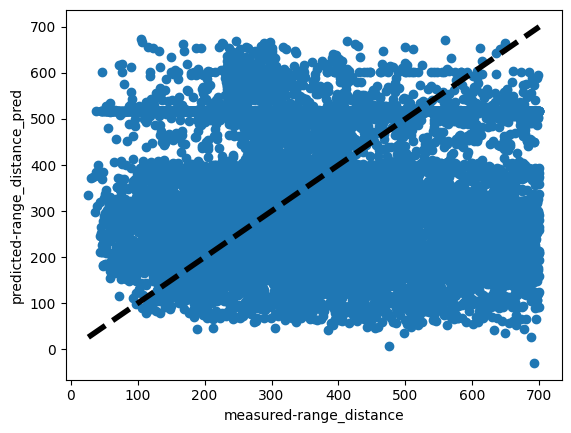

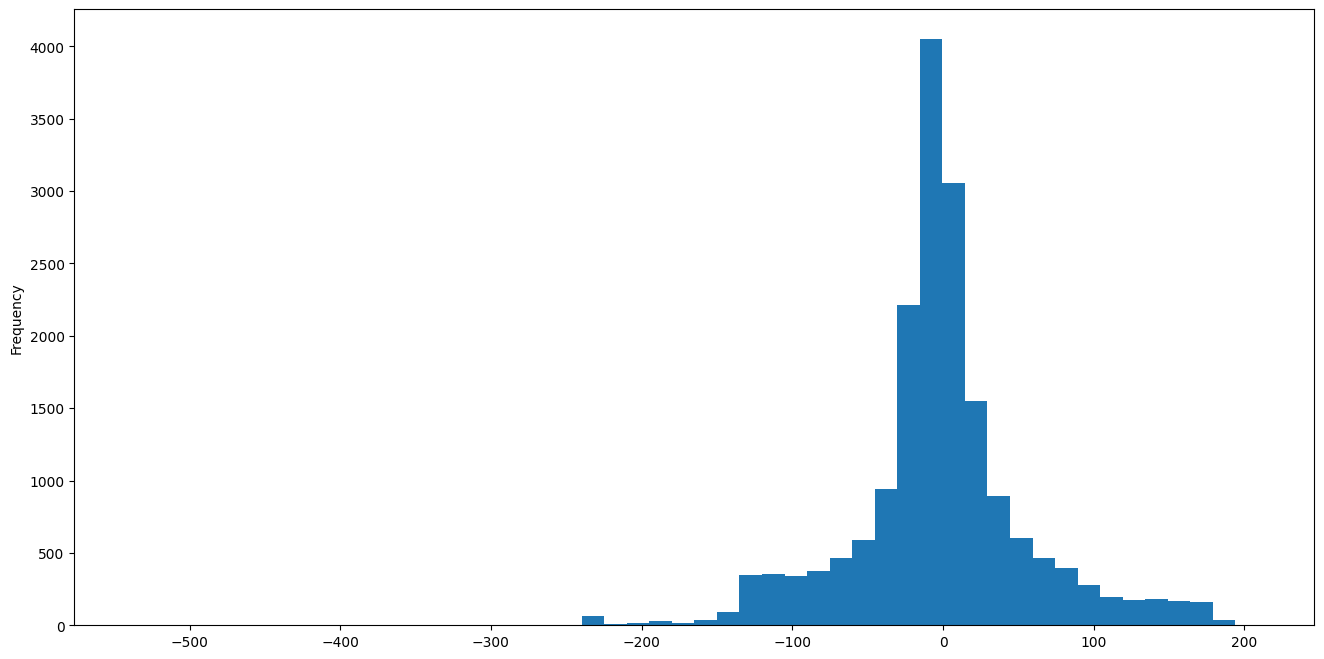

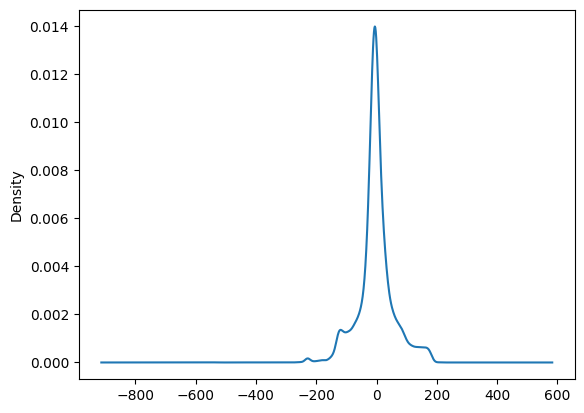

count    18113.000000
mean        -2.288522
std         59.122135
min       -539.000000
25%        -23.000000
50%         -4.000000
75%         19.000000
max        209.000000
Name: score, dtype: float64


In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

y_test = predictions['range_distance']
y_predicted = predictions['range_distance_pred']

ax.scatter(y_test, y_predicted)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('measured-range_distance')
ax.set_ylabel('predicted-range_distance_pred')
plt.show()


predictions['score'].plot(kind="hist", bins=50,figsize=(16,8))
plt.show()


predictions['score'].plot(kind="kde")
plt.show()

print(predictions['score'].describe(include=['category']))